# SJLT - Which method is best?
We want to know if it is faster to do the SJLT in serial or to tensorise and then concatenate.

In [37]:
import numpy as np
import pandas as pd
import scipy.sparse
import matplotlib.pyplot as plt
%matplotlib inline
%config Completer.use_jedi = False
import sys
import time

In [3]:
sys.path.append('/home/dickens/code/thesis-experiments/lib')

In [5]:
from sparse_jlt import SparseJLT 
from count_sketch import CountSketch
from sparse_data_converter import SparseDataConverter

First of all, let's generate some sparse data and test the serial version.
We will generate 

In [77]:
# Model setup
sparsity = 0.2
n = 100000
d = 500
sk_dim = 2*d
sjlt_sparsity = 10

# Data generation and conversion
X = scipy.sparse.random(n,d,density=sparsity).toarray()
print(X[0,:10])
sparse_data = SparseDataConverter(X).coo_data

[0.         0.24383901 0.         0.         0.         0.
 0.         0.         0.         0.11853543]


In [78]:
%%time
serial = SparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
serial.set_sparse_data(sparse_data)
serial.sketch(sparse_data)

CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 261 ms


In [126]:
import numpy as np
from math import sqrt as m_sqrt
from numba import njit
from matrix_sketch import MatrixSketch
from count_sketch import CountSketch, fast_countSketch
from sparse_data_converter import SparseDataConverter
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix

class TensorSparseJLT(CountSketch):
    """
    Class wrapper for the Sparse Johnson Lindesntrauss Transform of Kane and Nelson


    1. Generate `s` independent countsketches each of size m/s x n and concatenate them.
    2. Use initial hash functions as decided above in the class definition and then generate new hashes for
    subsequent countsketch calls.
    """
    def __init__(self,sketch_dim:int, n_data_rows:int, \
        n_data_cols:int,col_sparsity:int):
        """
        # TODO: docstring
        ...
        """
        super(TensorSparseJLT,self).__init__(sketch_dim,n_data_rows, n_data_cols)
        self.col_sparsity = col_sparsity
        assert self.col_sparsity > 1
        self.sjlt_proj_dim = self.sketch_dim // self.col_sparsity
        self.all_sketches = np.zeros((self.col_sparsity,self.sjlt_proj_dim,self.n_data_cols))

    def _sample_hashes(self,seed=100):
        """
        returns the row and sign hash functions for SJLT
        """
        np.random.seed(seed)
        # ! NB row map is used for indexing so MUST be an int!!!
#         row_map = np.zeros((self.col_sparsity,self.n_data_rows),dtype=int)
#         sign_map = np.zeros((self.col_sparsity,self.n_data_rows))
#         for _ in range(self.col_sparsity):
#             np.random.seed(seed + _)
#             row_map[_,:] = np.random.choice(self.sjlt_proj_dim,self.n_data_rows,replace=True)
#             sign_map[_,:] = np.random.choice([-1.,1.], self.n_data_rows, replace=True) 
        row_map = np.random.randint(low=0,high=self.sjlt_proj_dim,size=(self.col_sparsity,self.n_data_rows))
        sign_map = np.random.choice([-1., 1.],size=(self.col_sparsity,self.n_data_rows))
        return row_map, sign_map


    def sketch(self,mat,seed=100):
        """
        # TODO - Insert Doc string
        """
        if not self.sparse_data_flag:
            self.get_sparse_data(mat)
        self.sketch_matrix = np.zeros((self.sketch_dim,self.n_data_cols),dtype=float)
        rows,signs = self._sample_hashes(seed)
        for face in range(self.col_sparsity):
            rmap = rows[face,:]
            smap = signs[face,:]
            self.all_sketches[face,:,:] = fast_countSketch(np.zeros((self.sjlt_proj_dim,self.n_data_cols),dtype=float),
                    self.rows,
                    self.cols,
                    self.vals,
                    smap,
                    rmap)
        self.sketch_matrix = np.concatenate(self.all_sketches,axis=0)
        
    def explicit_sketch(self,mat,seed=100):
        rows,signs = self._sample_hashes(seed)
        sk = coo_matrix((self.col_sparsity,self.sketch_dim,self.n_data_rows))
        for face in range(self.col_sparsity):
            print(sk[face,:,:].shape, rows[face,:].shape)
            sk[face,rows[face,:],:] = signs[face,:]

#         
#         sk[range(self.col_sparsity),rows[]]
#         S = csr_matrix(shape=(self.col_sparsity,self.sketch_dim,self.n_data_cols),dtype=float)
            
#         local_summary = np.zeros((self.sjlt_proj_dim,self.n_data_cols),dtype=float)
#         rows,signs = self._sample_hashes(seed)

#         for batch in range(self.col_sparsity):
#             rmap = rows[batch,:]
#             smap = signs[batch,:]
#             B = fast_countSketch(np.zeros((self.sjlt_proj_dim,self.n_data_cols),dtype=float),
#                     self.rows,
#                     self.cols,
#                     self.vals,
#                     smap,
#                     rmap)
            
#             id_start, id_end = batch*self.sjlt_proj_dim,(batch+1)*self.sjlt_proj_dim
#             self.sketch_matrix[id_start:id_end,:] = B
        self.sketch_matrix /= m_sqrt(self.col_sparsity)



In [127]:
#%%time
tensor = TensorSparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
tensor.set_sparse_data(sparse_data)
tensor.sketch(sparse_data)

In [128]:
tensor.explicit_sketch(sparse_data)

TypeError: invalid input format

In [101]:
tensor.sketch_matrix.shape

(1000, 500)

In [129]:
coo_matrix((4,5,10))

TypeError: invalid input format

## Profiling
Now let's set some test instance and evaluate the time.

1. Performance wrt $n$
2. Performance wrt $d$
3. Performance wrt sparsity
4. Performance wrt column sparsity

In [54]:
nn = [50000,100000,150000,200000,500000, 1000000]
serial_time = np.zeros(len(nn),dtype=float)
tensor_time = np.zeros(len(nn),dtype=float)
trials = 5

for i,n in enumerate(nn):
    print(f'Testing:{i}, n={n}')
    sparsity = 0.2
    d = 200
    sk_dim = 2*d
    sjlt_sparsity = 10
    
    # # Data generation and conversion
    X = scipy.sparse.random(n,d,density=sparsity).toarray()
    sparse_data = SparseDataConverter(X).coo_data
    
    # Sketching setup
    serial = SparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    serial.set_sparse_data(sparse_data)
    tensor = TensorSparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    tensor.set_sparse_data(sparse_data)
    
    # Serial timing
    s_time = time.time()
    for t in range(trials):
        serial.sketch(sparse_data)
    serial_time[i] = (time.time() - s_time)/trials
    
    # Tensor timing
    t_time = time.time()
    for t in range(trials):
        tensor.sketch(sparse_data)
    tensor_time[i] = (time.time() - t_time)/trials
    

Testing:0, n=50000
Testing:1, n=100000
Testing:2, n=150000
Testing:3, n=200000
Testing:4, n=500000
Testing:5, n=1000000


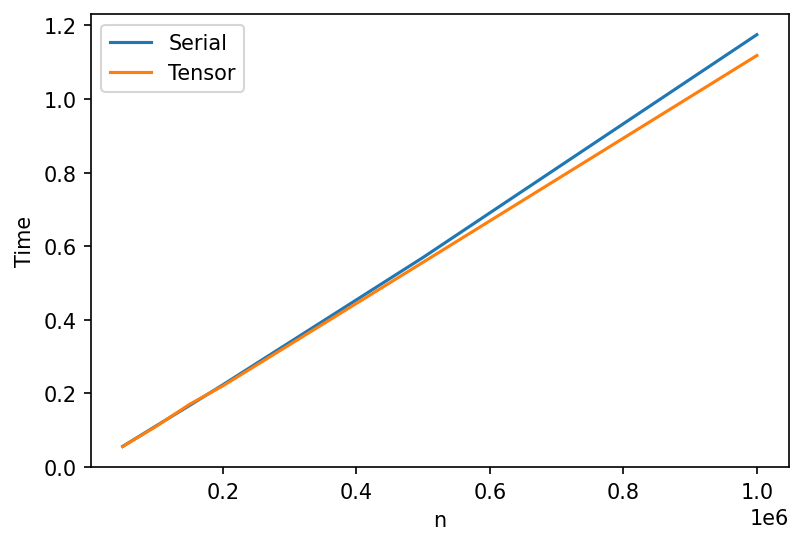

In [55]:
fig, ax = plt.subplots(dpi=150)
ax.plot(nn, serial_time,label='Serial')
ax.plot(nn, tensor_time,label='Tensor')
ax.set_xlabel('n')
ax.set_ylabel('Time')
ax.legend()

In [56]:
dd = [50,100,500,1000]
serial_time = np.zeros(len(dd),dtype=float)
tensor_time = np.zeros(len(dd),dtype=float)
trials = 5

for i,d in enumerate(dd):
    print(f'Testing:{i}, d={d}')
    sparsity = 0.2
    n = 500000
    sk_dim = 2*d
    sjlt_sparsity = 10
    
    # # Data generation and conversion
    X = scipy.sparse.random(n,d,density=sparsity).toarray()
    sparse_data = SparseDataConverter(X).coo_data
    
    # Sketching setup
    serial = SparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    serial.set_sparse_data(sparse_data)
    tensor = TensorSparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    tensor.set_sparse_data(sparse_data)
    
    # Serial timing
    s_time = time.time()
    for t in range(trials):
        serial.sketch(sparse_data)
    serial_time[i] = (time.time() - s_time)/trials
    
    # Tensor timing
    t_time = time.time()
    for t in range(trials):
        tensor.sketch(sparse_data)
    tensor_time[i] = (time.time() - t_time)/trials
    

Testing:0, d=50
Testing:1, d=100
Testing:2, d=500
Testing:3, d=1000


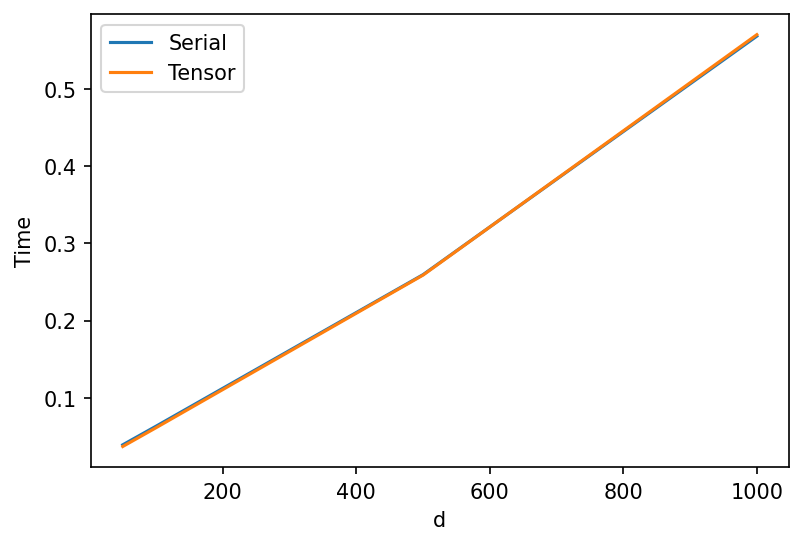

In [57]:
fig, ax = plt.subplots(dpi=150)
ax.plot(dd, serial_time,label='Serial')
ax.plot(dd, tensor_time,label='Tensor')
ax.set_xlabel('d')
ax.set_ylabel('Time')
ax.legend()

In [58]:
densities = [0.01, 0.1, 0.25, 0.5]
serial_time = np.zeros(len(densities),dtype=float)
tensor_time = np.zeros(len(densities),dtype=float)
trials = 5

for i,rho in enumerate(densities):
    print(f'Testing:{i}, rho={rho}')
    n = 500000
    d = 200 
    sk_dim = 2*d
    sjlt_sparsity = 10
    
    # # Data generation and conversion
    X = scipy.sparse.random(n,d,density=rho).toarray()
    sparse_data = SparseDataConverter(X).coo_data
    
    # Sketching setup
    serial = SparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    serial.set_sparse_data(sparse_data)
    tensor = TensorSparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=sjlt_sparsity)
    tensor.set_sparse_data(sparse_data)
    
    # Serial timing
    s_time = time.time()
    for t in range(trials):
        serial.sketch(sparse_data)
    serial_time[i] = (time.time() - s_time)/trials
    
    # Tensor timing
    t_time = time.time()
    for t in range(trials):
        tensor.sketch(sparse_data)
    tensor_time[i] = (time.time() - t_time)/trials
    

Testing:0, rho=0.01
Testing:1, rho=0.1
Testing:2, rho=0.25
Testing:3, rho=0.5


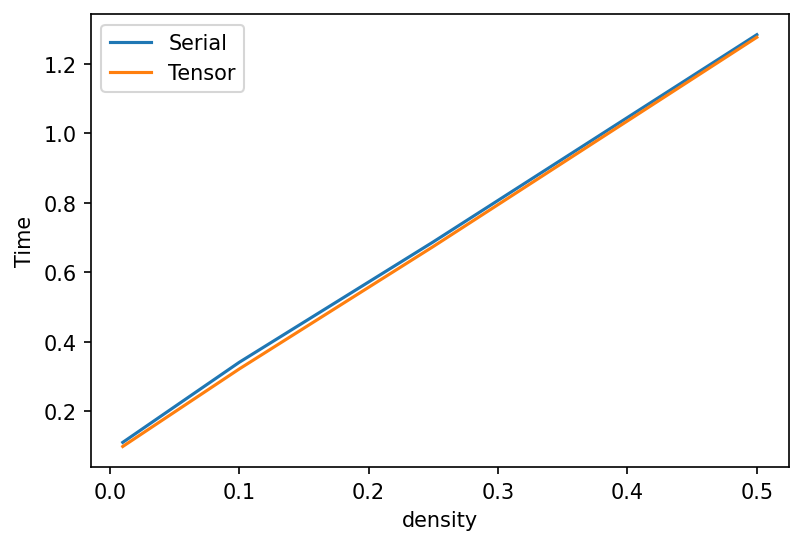

In [59]:
fig, ax = plt.subplots(dpi=150)
ax.plot(densities, serial_time,label='Serial')
ax.plot(densities, tensor_time,label='Tensor')
ax.set_xlabel('density')
ax.set_ylabel('Time')
ax.legend()

In [60]:
col_sparsities = [2,4,6,8,10,20]
serial_time = np.zeros(len(col_sparsities),dtype=float)
tensor_time = np.zeros(len(col_sparsities),dtype=float)
trials = 5

for i,c in enumerate(col_sparsities):
    print(f'Testing:{i}, c={c}')
    n = 500000
    d = 200 
    sk_dim = 2*d
    sparsity = 0.2
    
    # # Data generation and conversion
    X = scipy.sparse.random(n,d,density=sparsity).toarray()
    sparse_data = SparseDataConverter(X).coo_data
    
    # Sketching setup
    serial = SparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=c)
    serial.set_sparse_data(sparse_data)
    tensor = TensorSparseJLT(sketch_dim=sk_dim,n_data_rows=n,n_data_cols=d,col_sparsity=c)
    tensor.set_sparse_data(sparse_data)
    
    # Serial timing
    s_time = time.time()
    for t in range(trials):
        serial.sketch(sparse_data)
    serial_time[i] = (time.time() - s_time)/trials
    
    # Tensor timing
    t_time = time.time()
    for t in range(trials):
        tensor.sketch(sparse_data)
    tensor_time[i] = (time.time() - t_time)/trials
    

Testing:0, c=2
Testing:1, c=4
Testing:2, c=6
Testing:3, c=8
Testing:4, c=10
Testing:5, c=20


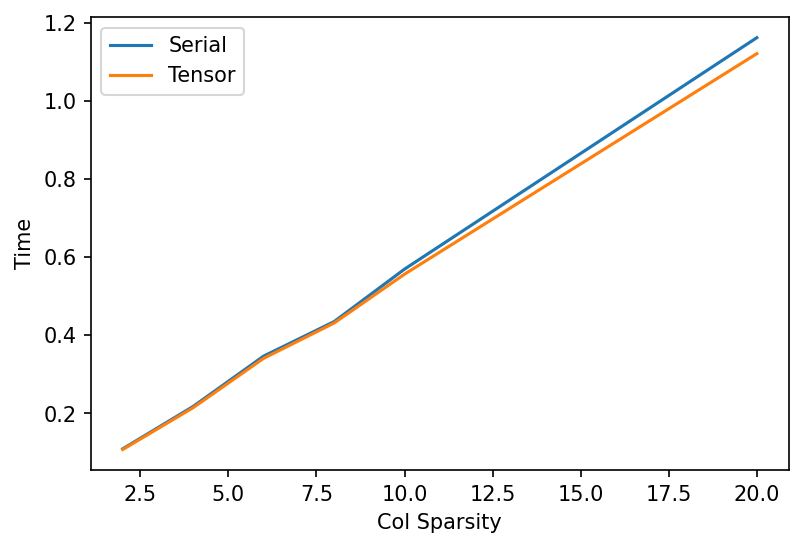

In [61]:
fig, ax = plt.subplots(dpi=150)
ax.plot(col_sparsities, serial_time,label='Serial')
ax.plot(col_sparsities, tensor_time,label='Tensor')
ax.set_xlabel('Col Sparsity')
ax.set_ylabel('Time')
ax.legend()